# Crossvalidation of the Hyperlocal Models

In [1]:
# !pip3 install simdkalman fbprophet scipy==1.2 statsmodels --upgrade

In [2]:
import math
import datetime
import random
import time
import multiprocessing

import numpy as np
import pandas as pd

import simdkalman

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import tensorflow.keras as tfk

import _pickle as cPickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

## The Data

Load the preprocessed data

In [3]:
# !gsutil cp gs://franzfiles/full_data.csv .

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# cd '/content/gdrive/My Drive/Colab Notebooks/aiforsea'

In [6]:
df = pd.read_csv('full_data.csv')
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632


### Add info for fbprophet

In [7]:
# mask = np.load('temporal_anomaly_detection/density_mask.npy')
# flat_mask = mask.reshape(-1).astype('float32')
# mask_sum = mask.sum()

In [8]:
# def scaled_loss(inputs, outputs):
#   outputs *= flat_mask
#   loss = tfk.metrics.mean_squared_error(inputs, outputs)
#   return mask_sum * loss
# 
# autoencoder = tfk.models.load_model('temporal_anomaly_detection/autoencoder.h5',
#                                     custom_objects={'scaled_loss':scaled_loss})

In [9]:
mahalanobis_dist = np.load('temporal_anomaly_detection/mahalanobis_dist.npy')
# train_mu  = np.load('temporal_anomaly_detection/train_mu.npy')
# train_std = np.load('temporal_anomaly_detection/train_std.npy')

In [10]:
df['is_anomaly'] = (df['day'] - 1)*4*24 + df['hour']*4 + df['minutes']//15
df['is_anomaly'] = df['is_anomaly'].apply(lambda x : mahalanobis_dist[x] > 4.0)

In [11]:
df['is_weekend'] = (4 <= (df['day'].values % 7 )) & ((df['day'].values % 7) <= 5)
df['is_weekday'] = ~(df['is_weekend'])
df['cap']   = 1.0
df['floor'] = 0.0
df.head()

,geohash6,day,demand,in_raw,weekday,hour,minutes,ds,latitude,longitude,is_anomaly,is_weekend,is_weekday,cap,floor
0,qp02yc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.653687,False,False,True,1.0,0.0
1,qp02z1,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.664673,False,False,True,1.0,0.0
2,qp02z3,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.675659,False,False,True,1.0,0.0
3,qp02z9,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.686646,False,False,True,1.0,0.0
4,qp02zc,1,0.0,False,1,0,0,1900-01-01 00:00:00,-5.484924,90.697632,False,False,True,1.0,0.0


In [12]:
df = df.drop(['in_raw', 'weekday', 'hour', 'minutes', 'latitude', 'longitude'], axis=1)
df = df.rename(columns={'demand' : 'y'})
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,geohash6,day,y,ds,is_anomaly,is_weekend,is_weekday,cap,floor
0,qp02yc,1,0.0,1900-01-01,False,False,True,1.0,0.0
1,qp02z1,1,0.0,1900-01-01,False,False,True,1.0,0.0
2,qp02z3,1,0.0,1900-01-01,False,False,True,1.0,0.0
3,qp02z9,1,0.0,1900-01-01,False,False,True,1.0,0.0
4,qp02zc,1,0.0,1900-01-01,False,False,True,1.0,0.0


### Collect info for each location

In [13]:
locations = df['geohash6'].unique()
print(len(locations), locations)

1329 ['qp02yc' 'qp02z1' 'qp02z3' ... 'qp0djw' 'qp0djy' 'qp0dnn']


In [14]:
%%time
gb = df.groupby('geohash6')    
location_series = {}
for x in gb.groups:
    group = gb.get_group(x).reset_index().drop('index', axis=1)
    location_series[x] = group

Wall time: 18.2 s


## Model Selection

### Define training horizon and phase

In [15]:
train_start = pd.to_datetime('1900-01-20 00:00:00')
train_stepdelta = datetime.timedelta(days=1, hours=1, minutes=15)
train_horizon = datetime.timedelta(days=14)

In [16]:
TIMESTEPS = 20

### Select locations

In [17]:
locations_subset = np.random.choice(locations, size=len(locations)//10)

### Test on a location

In [71]:
series = location_series['qp09d9']
# forecast using fbprophet's default settings
fbm1 = Prophet(seasonality_mode='multiplicative',
               weekly_seasonality=True,
               yearly_seasonality=False)
fbm1.add_regressor('is_anomaly')
fbm1.fit(series)

In [72]:
future = fbm1.make_future_dataframe(periods=5, freq='15min', include_history=True)
future['is_anomaly'] = np.concatenate((series['is_anomaly'].values, np.zeros(5)), axis=None)
forecast1 = fbm1.predict(future)

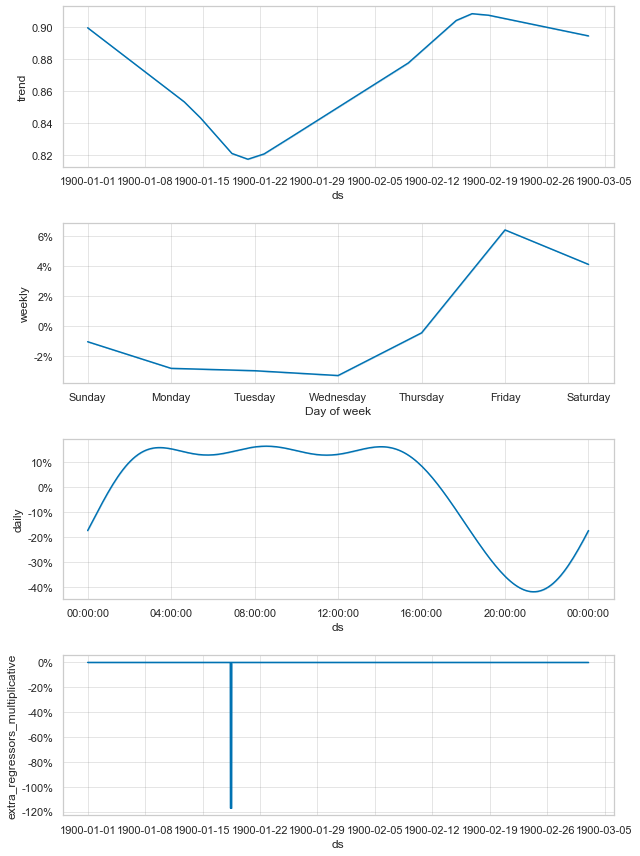

In [73]:
fig2 = fbm1.plot_components(forecast1)

### Crossvalidate the models

In [18]:
def worker(timestep, df_data, return_dict):
    # train-test split
    df_train = df_data.iloc[:-5]
    df_test  = df_data.iloc[-5:]
    X_train = np.arange(len(df_train)).reshape(-1, 1)
    X_test  = (np.arange(5) + len(df_train)).reshape(-1, 1)

    # forecast using data from previous cycle
    prev_pred = df_train['y'].values[-4*24: -4*24+5]

    # forecast using Keano Reeves
    kf = simdkalman.KalmanFilter(
      state_transition = np.array([[1,1],[0,1]]),
      process_noise = np.diag([0.1, 0.01]),
      observation_model = np.array([[1,0]]),
      observation_noise = 0.5)
    kalman_pred = kf.predict(df_train['y'].values, 5).states.mean[:,0]

    # deseasonalize
    decomposition = sm.tsa.seasonal_decompose(df_train['y'] + 1e-9,
                                            model='multiplicative',
                                            freq=4*24,
                                            two_sided=False,
                                            extrapolate_trend=1)
    df_train['deseasonalized'] = df_train['y'].values / (decomposition.seasonal + 1e-9)
    seasonal_test = decomposition.seasonal.values[-4*24:-4*24+5]

    # forecast using theta = 0 (with linear regression)
    linreg = HuberRegressor().fit(X_train, df_train['deseasonalized'].values)
    theta0_pred = linreg.predict(X_test)
    y0_pred = theta0_pred * seasonal_test

    # forecast using theta = 2 (with simple exponential smoothing)
    y_theta2 = 2*df_train['deseasonalized'].values - linreg.predict(X_train)
    ses = SimpleExpSmoothing(y_theta2).fit()
    theta2_pred = ses.forecast(5)
    y2_pred = theta2_pred * seasonal_test

    # forecast using fbprophet's default settings
    fbm1 = Prophet(seasonality_mode='multiplicative',
                   weekly_seasonality=True,
                   yearly_seasonality=False)
    fbm1.add_regressor('is_anomaly')
    fbm1.fit(df_train)
    
    future = fbm1.make_future_dataframe(periods=5, freq='15min', include_history=False)
    future['is_anomaly'] = 0
    forecast1 = fbm1.predict(future)


    # combinations
    # all_pred            = (prev_pred + kalman_pred + y0_pred + y2_pred + forecast1['yhat'].values) / 5.0

    # clip
    # prev_pred           = np.clip(prev_pred               , a_min=0.0, a_max=1.0)
    kalman_pred         = np.clip(kalman_pred             , a_min=0.0, a_max=1.0)
    y0_pred             = np.clip(y0_pred                 , a_min=0.0, a_max=1.0)
    y2_pred             = np.clip(y2_pred                 , a_min=0.0, a_max=1.0)
    forecast1['yhat']   = np.clip(forecast1['yhat'].values, a_min=0.0, a_max=1.0)
    # all_pred            = np.clip(all_pred                , a_min=0.0, a_max=1.0)

    # save
    predictions = np.asarray([prev_pred,
                              kalman_pred,
                              y0_pred,
                              y2_pred,
                              forecast1['yhat'].values])
    actuals = df_test['y'].values
    
    return_dict[timestep] = {'predictions' : predictions,
                             'actuals'     : actuals}

In [22]:
%%time

predictions = []
actuals     = []
for location in ['qp02zw']:
    # location = locations_subset[iloc]
    # print("{}/{} - currently processing location {}".format(iloc+1, len(locations_subset), location))
    
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    jobs = []
    for i in range(TIMESTEPS):      
        start_date = train_start + i*train_stepdelta
        end_date   = start_date + train_horizon
        print(start_date, end_date)
        
        df_loc = location_series[location]
        df_loc = df_loc[(start_date <= df_loc['ds']) & (df_loc['ds'] <= end_date)]
        df_loc = df_loc.reset_index().drop('index', axis=1)
        worker(i, df_loc, return_dict)
#         
#         df_loc = location_series[location]
#         df_loc = df_loc[(start_date <= df_loc['ds']) & (df_loc['ds'] <= end_date)]
#         df_loc = df_loc.reset_index().drop('index', axis=1)
#         
#         p = multiprocessing.Process(target=worker, args=(i, df_loc, return_dict))
#         jobs.append(p)
#         p.start()
# 
#     for proc in jobs:
#         proc.join()

    predictions.append(np.stack([return_dict[i]['predictions'] for i in range(TIMESTEPS)], axis=0))
    actuals.append(np.stack([return_dict[i]['actuals']     for i in range(TIMESTEPS)], axis=0))

predictions = np.asarray(predictions)
actuals     = np.asarray(actuals)
print(predictions.shape, actuals.shape)

1900-01-20 00:00:00 1900-02-03 00:00:00
1900-01-21 01:15:00 1900-02-04 01:15:00
1900-01-22 02:30:00 1900-02-05 02:30:00
1900-01-23 03:45:00 1900-02-06 03:45:00
1900-01-24 05:00:00 1900-02-07 05:00:00
1900-01-25 06:15:00 1900-02-08 06:15:00
1900-01-26 07:30:00 1900-02-09 07:30:00
1900-01-27 08:45:00 1900-02-10 08:45:00
1900-01-28 10:00:00 1900-02-11 10:00:00
1900-01-29 11:15:00 1900-02-12 11:15:00
1900-01-30 12:30:00 1900-02-13 12:30:00
1900-01-31 13:45:00 1900-02-14 13:45:00
1900-02-01 15:00:00 1900-02-15 15:00:00
1900-02-02 16:15:00 1900-02-16 16:15:00
1900-02-03 17:30:00 1900-02-17 17:30:00
1900-02-04 18:45:00 1900-02-18 18:45:00
1900-02-05 20:00:00 1900-02-19 20:00:00
1900-02-06 21:15:00 1900-02-20 21:15:00
1900-02-07 22:30:00 1900-02-21 22:30:00
1900-02-08 23:45:00 1900-02-22 23:45:00
(1, 20, 5, 5) (1, 20, 5)
Wall time: 2min 11s


### Evaluate the models

In [23]:
prev_mse_sum           = 0
kalman_mse_sum         = 0

y0_mse_sum             = 0
y2_mse_sum             = 0
theta_mse_sum          = 0

fbm1_mse_sum           = 0

all_mse_sum            = 0

In [24]:
for i in range(len(predictions)):
    for t in range(TIMESTEPS):
        prev_mse_sum   += mean_squared_error(predictions[i][t][0], actuals[i][t])
        kalman_mse_sum += mean_squared_error(predictions[i][t][1], actuals[i][t])
        y0_mse_sum     += mean_squared_error(predictions[i][t][2], actuals[i][t])
        y2_mse_sum     += mean_squared_error(predictions[i][t][3], actuals[i][t])
        fbm1_mse_sum   += mean_squared_error(predictions[i][t][4], actuals[i][t])
        
        theta_pred = (predictions[i][t][2] + predictions[i][t][3]) / 2.0
        theta_pred = np.clip(theta_pred, a_min=0.0, a_max=1.0)
        theta_mse_sum  += mean_squared_error(theta_pred, actuals[i][t])
        
        # all_pred   = predictions[i][t].mean(axis=0)
        all_pred = (predictions[i][t][0] + predictions[i][t][1] + theta_pred + predictions[i][t][4]) / 4.0
        all_mse_sum    += mean_squared_error(all_pred, actuals[i][t])

In [26]:
print("prev_rmse           ", math.sqrt(prev_mse_sum          /(TIMESTEPS * len(predictions))))
print("kalman_rmse         ", math.sqrt(kalman_mse_sum        /(TIMESTEPS * len(predictions))))
print("y0_rmse             ", math.sqrt(y0_mse_sum            /(TIMESTEPS * len(predictions))))
print("y2_rmse             ", math.sqrt(y2_mse_sum            /(TIMESTEPS * len(predictions))))
print("fbm1_rmse           ", math.sqrt(fbm1_mse_sum          /(TIMESTEPS * len(predictions))))
# print("fbm2_rmse           ", math.sqrt(fbm2_mse_sum          /(TIMESTEPS * len(predictions))))
# print("theta_fb1_rmse      ", math.sqrt(theta_fb1_mse_sum     /(TIMESTEPS * len(predictions))))
# print("theta_fb2_rmse      ", math.sqrt(theta_fb2_mse_sum     /(TIMESTEPS * len(predictions))))
# print("theta_fb1_prev_rmse ", math.sqrt(theta_fb1_prev_mse_sum/(TIMESTEPS * len(predictions))))
# print("theta_fb2_prev_rmse ", math.sqrt(theta_fb2_prev_mse_sum/(TIMESTEPS * len(predictions))))
print("theta_rmse          ", math.sqrt(theta_mse_sum         /(TIMESTEPS * len(predictions))))
print("all_rmse            ", math.sqrt(all_mse_sum           /(TIMESTEPS * len(predictions))))

prev_rmse            0.07980296192739604
kalman_rmse          0.09829175225854198
y0_rmse              0.08463593714537263
y2_rmse              0.1157874603786236
fbm1_rmse            0.06820627883046501
theta_rmse           0.07462596287235407
all_rmse             0.05649223125013117


In [25]:
prev_rmse            0.07980296192739604
kalman_rmse          0.09829175225854198
y0_rmse              0.08463594529766318
y2_rmse              0.11578745803879455
fbm1_rmse            0.0685048706433476
theta_rmse           0.07462596399847413
all_rmse             0.05658998701722148

SyntaxError: invalid syntax (<ipython-input-25-6b57b8d4bbe1>, line 1)

### Save 

In [ ]:
np.save('predictions.npy', predictions)

In [ ]:
np.save('actuals.npy', actuals)

In [ ]:
np.save('locations_subset.npy', locations_subset)